<img src="imgs/IISc_Master_Seal_Black_Transparent.png" height="120px" width="120px" align="right" />

<img src="imgs/logoGESS.jpg" height="120px" width="120px" align="right" />

<font face="Calibri">
<br>
<font size="7"> <b> PySHBundle Tutorials </b> </font>
<br> <br>
<font size="5"> <b> Tutorial 2: Load Spherical Harmonics data from JPL, CSR and ITSG<font color='rgba(200,0,0,0.2)'>  </font> </b> </font>
<br> <br>
    
<font size="3"> <b> by: Abhishek Mhamane, IIT Kanpur</b> 
<font size="2">  <br>
<font> <b>Date: </b> August 23, 2023 </font>
</font>


In [3]:
import os
import pprint
import numpy as np
from tqdm import tqdm, trange
from datetime import datetime
import pyshbundle

In [4]:
from pyshbundle.new_io import read_jpl, read_csr, read_tn13, read_tn14, extract_C10_11_replcmnt_coeff, klm2sc_new
from pyshbundle.new_io import extract_C20_replcmnt_coeff, extract_C30_replcmnt_coeff, replace_zonal_coeff, find_date_in_replacemnt_file
from pyshbundle.new_io import read_itsg

## 1.1 GRACE Level-2 Data

This dataset contains estimates of the total month-by-month geopotential of the Earth, derived from the Gravity Recovery and Climate Experiment Follow-On (GRACE-FO) mission measurements

For more details refer to [GRACE Products by GFZ Postdam](https://www.gfz-potsdam.de/en/section/global-geomonitoring-and-gravity-field/projects/grace/grace-products)

## Data Source - CSR

Data loading steps are more or less similar for different data sources, still procedure for different sources have been explained in this tutorial.

In [5]:
# get the absolute paths to the data folders
csr_folder = '/media/abhishek/DATA/projects/prod_fork/pyshbundle/sample_input_data/CSR_input'
source = 'csr'

# single file path 
csr_file_path = '/media/abhishek/DATA/projects/prod_fork/pyshbundle/sample_input_data/CSR_input/GSM-2_2002305-2002334_GRAC_UTCSR_BB01_0600.gz'

## Read the files (single and multiple files)

For the GRACE data files, the function `read_csr` parses the header info as well as the numerical data into a `dict` and `matrix` format respectively. <br>

for additional information see the documentation or use `help(read_csr)`

### Single file

In [6]:
csr_header, klm_mat, start_date, end_date = read_csr(csr_file_path)

In [7]:
# pretty printing the header info
pp = pprint.PrettyPrinter(indent=2, width=2, compact=True)
pp.pprint(csr_header)

{ 'degree': 96,
  'earth_gravity_param': { 'units': 'm3/s2',
                           'value': 398600441500000.0},
  'institution': 'UT-AUSTIN/CSR',
  'mean_equator_radius': { 'units': 'meters',
                           'value': 6378136.3},
  'normalization': 'fully '
                   'normalized',
  'order': 96,
  'permanent_tide_flag': 'inclusive',
  'processing_level': '2',
  'product_version': 'RL06',
  'title': 'GRACE '
           'Geopotential '
           'Coefficients '
           'CSR '
           'RL06'}


The `klm_mat` contains the numerical data; of size (n, 6) <br> <br>

The columns of the matrix (np.ndarray) are [degree, order, c_lm, s_lm, dev_c_lm, dev_s_lm] <br>

NOTE: CSR provides data in the `KLM` format whereas JPL and ITSG provides in `CLM` format

In [8]:
# the numerical data
klm_mat[0:5]

array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.00000000e+00,  0.00000000e+00, -4.84169371e-04,
         0.00000000e+00,  4.08200000e-13,  0.00000000e+00],
       [ 3.00000000e+00,  0.00000000e+00,  9.57158484e-07,
         0.00000000e+00,  3.17400000e-13,  0.00000000e+00],
       [ 4.00000000e+00,  0.00000000e+00,  5.40012505e-07,
         0.00000000e+00,  3.15300000e-13,  0.00000000e+00]])

The shape of the `klm_mat` matrix indicates there are 4753 data rows in the 

In [9]:
print(klm_mat.shape)

(4753, 6)


The dates have been reported seperately so as to maintain consistency with data provided by other data processing centers.

In [10]:
# date flaot representation of date of YYYYMMDD -> just for consistency
print(f"start date: {(start_date)} and end date: {end_date}")


start date: {20021101.0} and end date: {20021201.0}


### Format conversion

In [11]:
# Currently the data is in an data matrix, for efficient computation it needs to converted to /S|C\ or |C\S| format
csr_sc, csr_dev_sc = klm2sc_new(klm_mat, 96)

Visualize the /C|S\ foramt

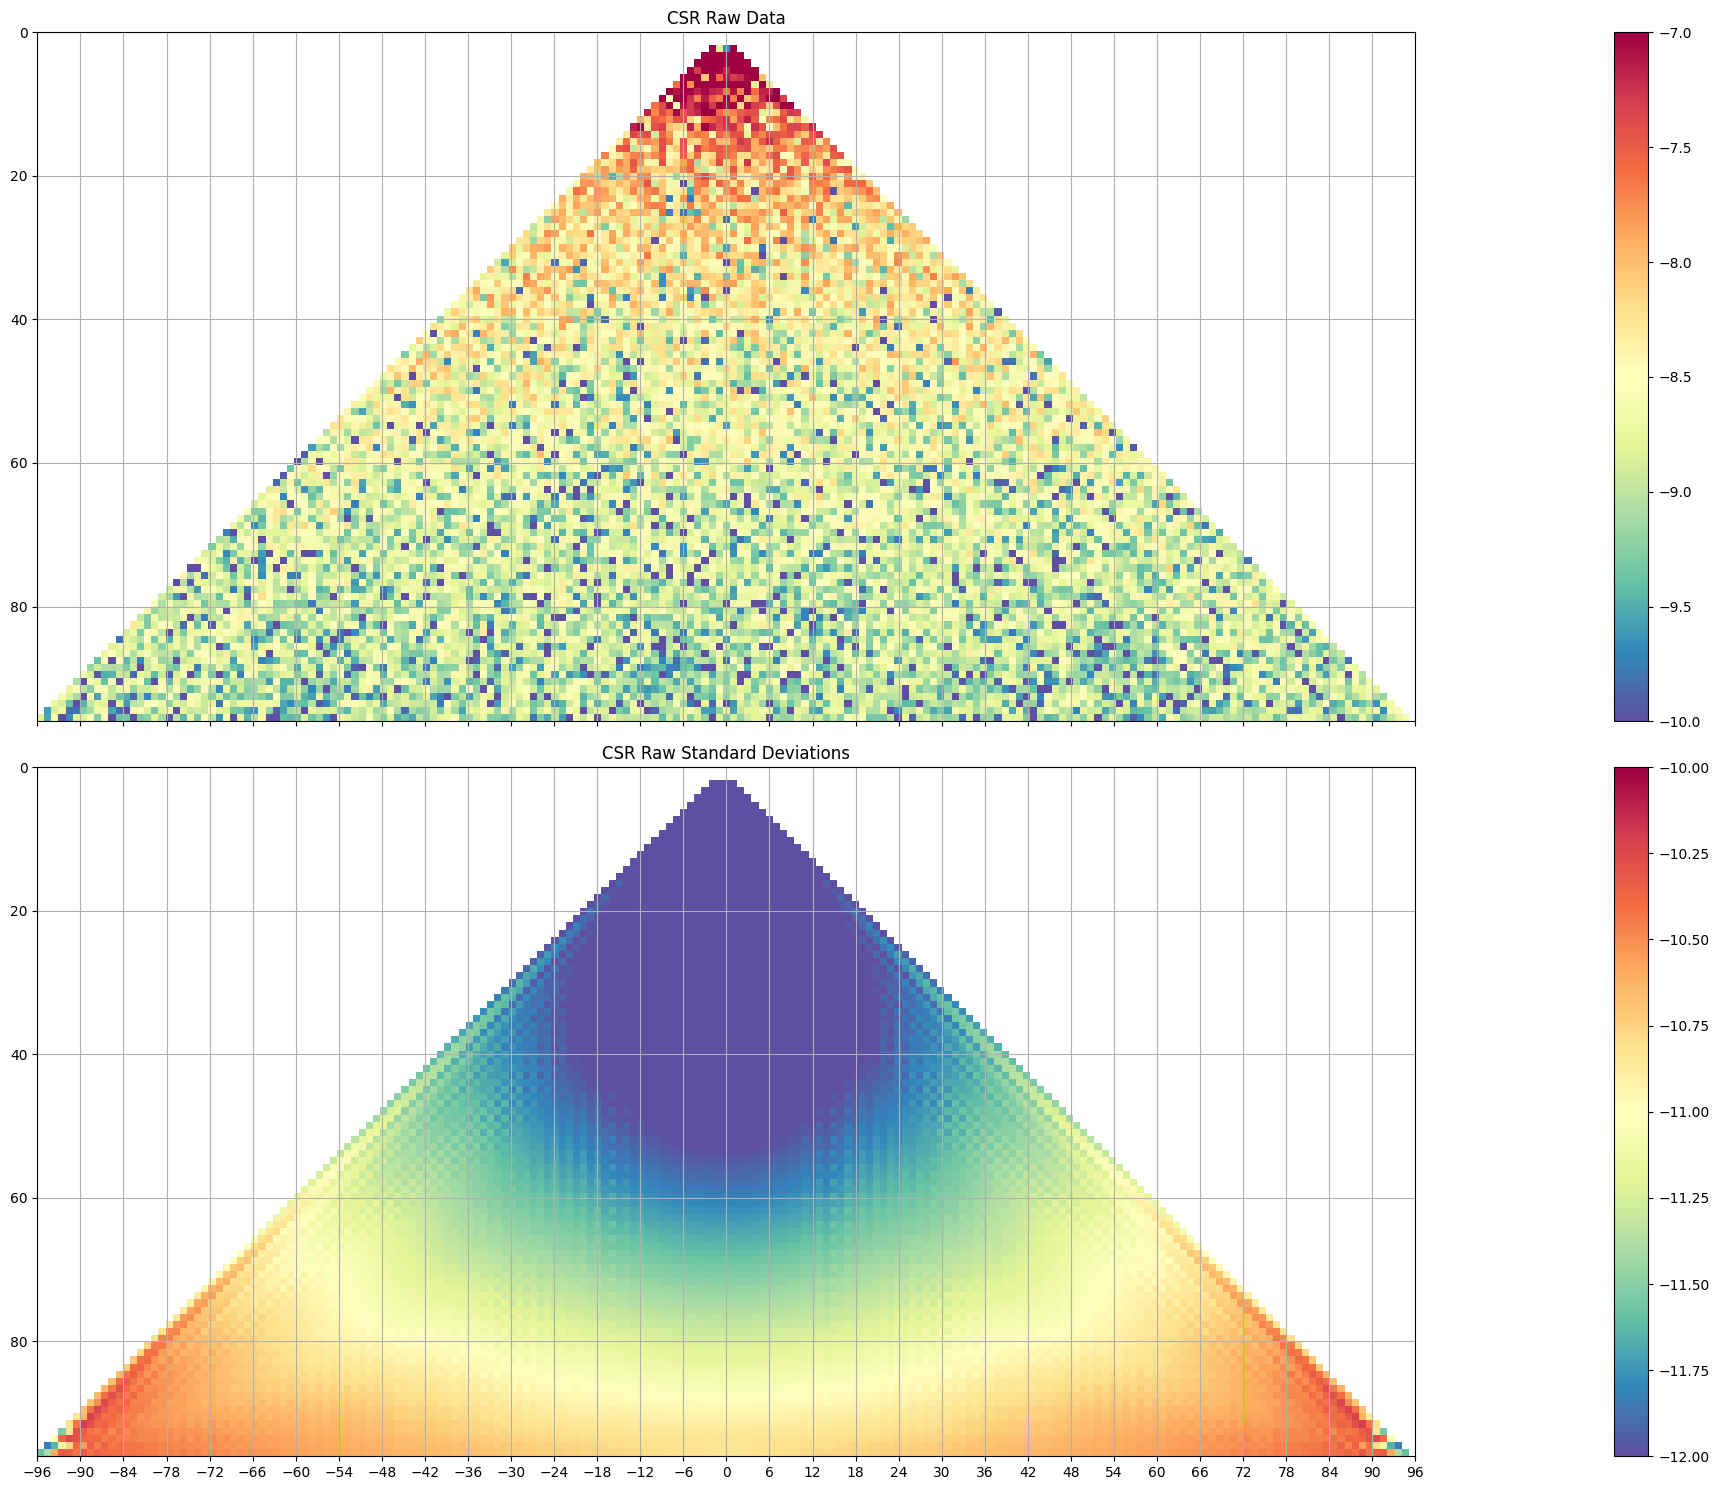

In [12]:
import matplotlib.pyplot as plt
x_vec = np.arange(-96, 96+1, 6)
y_vec = np.arange(96, -2, -6)

fig, ax = plt.subplots(2, 1,figsize=(40, 15), sharex=True, sharey=True)
raw_dat = ax[0].imshow(np.ma.log10(np.absolute(csr_sc)), extent=[-96, 96, 96, 0], cmap='Spectral_r', vmin=-10, vmax=-7, )
ax[0].title.set_text("CSR Raw Data")

fig.colorbar(raw_dat, )

raw_dev = ax[1].imshow(np.ma.log10(np.absolute(csr_dev_sc)), extent=[-96, 96, 96, 0], cmap='Spectral_r', vmin=-12, vmax=-10)
ax[1].title.set_text("CSR Raw Standard Deviations")
plt.sca(ax[1])
plt.xticks(x_vec, color='black')
fig.colorbar(raw_dev,)

ax[0].grid()
ax[1].grid()

# plt.colorbar()

fig.tight_layout()
plt.show()


### Reading Multiple Files

In order to read multiple files, a stack can be generated by iteration over the files, calling `read_jpl`,  `read_csr`,  `read_itsg` and appending the stack matrix or list

Ocassionally in order to maintain some sort of consistency in stacking, the files can be sorted before stacking.

In [13]:
# finds the date string chars in the file name for sorting purpose
def last_4chars(x):
        return(x[-39:-32])

In [14]:
# loading all the JPL files
files = os.listdir(csr_folder)
files = sorted(files, key = last_4chars)

# initialize the stacking matrix or stacking list
data_mat_csr = np.ndarray((len(files), 4753, 6))

# collecting all the begin and stop dates in a matrix
# later on can be converted to datetime object as and when required
dates_csr = np.ndarray((len(files), 2))
for i in trange(len(files)):
    file_path = csr_folder + '/' + files[i]
    header = read_csr(file_path)[0]
    data_mat_csr[i, :, :] = read_csr(file_path)[1]
    dates_csr[i, 0] = float(str(read_csr(file_path)[2])[1:-1])
    dates_csr[i, 1] = float(str(read_csr(file_path)[3])[1:-1])
    

100%|██████████| 212/212 [00:39<00:00,  5.41it/s]


In [15]:
print(data_mat_csr.shape)

(212, 4753, 6)


Similarly other sources like `JPL` and `ITSG` can be read and loaded into python for further processing.

The rest of steps scale similarly.

## Read Replacement files

Replacement data is provided in the Technical Notes 13 and 14. Which can be downloaded from the NASA JPL Tulus website.

In [16]:
# here example is shown for the csr replacement files

path_csr_tn13 = '/media/abhishek/DATA/projects/prod_fork/pyshbundle/pyshbundle/data/CSR_TN_files/TN-13_GEOC_CSR_RL06.1.txt'
path_csr_tn14 = '/media/abhishek/DATA/projects/prod_fork/pyshbundle/pyshbundle/data/CSR_TN_files/TN-14_C30_C20_SLR_GSFC.txt'


In [17]:
data_tn13_csr = read_tn13(path_csr_tn13)

The data is loaded in form of a matrix of format $[l, m, clm, slm, \sigma_{clm}, \sigma_{slm}, begin\ date, end\ date]$

In [18]:
data_tn13_csr[0:5, :]

array([[ 1.00000000e+00,  0.00000000e+00,  5.21793863e-10,
         0.00000000e+00,  4.45850000e-11,  0.00000000e+00,
         2.00204050e+07,  2.00205010e+07],
       [ 1.00000000e+00,  1.00000000e+00,  2.86777277e-10,
        -6.80704629e-11,  4.52960000e-11,  5.07240000e-11,
         2.00204050e+07,  2.00205010e+07],
       [ 1.00000000e+00,  0.00000000e+00,  4.69850864e-10,
         0.00000000e+00,  4.45850000e-11,  0.00000000e+00,
         2.00205030e+07,  2.00205180e+07],
       [ 1.00000000e+00,  1.00000000e+00,  1.53669799e-10,
        -8.90896621e-11,  4.52960000e-11,  5.07240000e-11,
         2.00205030e+07,  2.00205180e+07],
       [ 1.00000000e+00,  0.00000000e+00,  4.10788808e-13,
         0.00000000e+00,  4.45850000e-11,  0.00000000e+00,
         2.00208010e+07,  2.00209010e+07]])

In [19]:
data_tn14_csr = read_tn14(path_csr_tn14)

In [20]:
start_date

{20021101.0}

## Replace Low Degree Coefficients

In [21]:
# start date and end date are set 
# convert them to int first
start_date = int(list(start_date)[0])
end_date = int(list(end_date)[0])

In [22]:
replaced_data_mat = replace_zonal_coeff(klm_mat, 'csr', 96, data_tn13_csr, data_tn14_csr, start_date, end_date)


GRACE Data File - epoch-begin: 2002-11-01, epoch-end:; TN13-Products start: 2002-11-01, end: 2002-12-01
GRACE Data File - epoch-begin: 2002-11-01, epoch-end:; TN13-Products start: 2002-11-01, end: 2002-12-01
start: 2002-11-01, epoch-begin: 2002-11-01, LB:2002-10-27, UB: , end: 2002-12-01, epoch-end:
start: 2002-11-01, epoch-begin: 2002-11-01, LB:2002-10-27, UB: , end: 2002-12-01, epoch-end:


###  Let's Observe the Replacement Steps/Procedure

In [23]:
# This is the TN-13 Replacement file data from the matrix
epoch_begin = datetime.strptime(str(int(start_date)), '%Y%m%d').date()
tn_13_idx = find_date_in_replacemnt_file(data_tn13_csr, "tn-13", "csr", epoch_begin)
print(f"The TN-13 indices found to match : {tn_13_idx}")

GRACE Data File - epoch-begin: 2002-11-01, epoch-end:; TN13-Products start: 2002-11-01, end: 2002-12-01
GRACE Data File - epoch-begin: 2002-11-01, epoch-end:; TN13-Products start: 2002-11-01, end: 2002-12-01
The TN-13 indices found to match : [10, 11]


In [24]:
# This is the TN-14 Replacement file data from the matrix

epoch_begin = datetime.strptime(str(int(start_date)), '%Y%m%d').date()
tn_14_idx = find_date_in_replacemnt_file(data_tn14_csr, "tn-14", "csr", epoch_begin)
print(f"The TN-14 indices found to match : {tn_14_idx}")

start: 2002-11-01, epoch-begin: 2002-11-01, LB:2002-10-27, UB: , end: 2002-12-01, epoch-end:
The TN-14 indices found to match : [5]


In [25]:
# TN-13 Replacement data -> C10, C11, S11
data_tn13_csr[80:82, :]

array([[ 1.00000000e+00,  0.00000000e+00,  1.05218996e-11,
         0.00000000e+00,  4.45850000e-11,  0.00000000e+00,
         2.00511010e+07,  2.00512010e+07],
       [ 1.00000000e+00,  1.00000000e+00, -1.42764637e-10,
         1.92147850e-10,  4.52960000e-11,  5.07240000e-11,
         2.00511010e+07,  2.00512010e+07]])

In [26]:
# TN-14 Replacement data - C20, C30
data_tn14_csr[40, :]

array([-4.84169429e-04,  1.57500000e-11,             nan,             nan,
        2.87400000e-11,             nan,  5.36750000e+04,  5.37050000e+04])

In [27]:
rep_C10 = replaced_data_mat[1,:]
rep_C11_S11 = replaced_data_mat[96+1,:]
rep_C20 = replaced_data_mat[2,:]
rep_C30 = replaced_data_mat[3,:]

In [28]:
print(f"Unreplaced data {klm_mat[1, :]}\n \n TN-13: {data_tn13_csr[80:82, :-2][0]} \n \n Replaced C10: {rep_C10}; \n")

Unreplaced data [1. 0. 0. 0. 0. 0.]
 
 TN-13: [1.00000000e+00 0.00000000e+00 1.05218996e-11 0.00000000e+00
 4.45850000e-11 0.00000000e+00] 
 
 Replaced C10: [1.00000000e+00 0.00000000e+00 1.32473791e-10 0.00000000e+00
 4.45850000e-11 0.00000000e+00]; 



In [29]:
print(f"Unreplaced data {klm_mat[97, :]}\n  \nTN-13: {data_tn13_csr[80:82, :-2][1]} \n \n Replaced C11_S11: {rep_C11_S11};")

Unreplaced data [1. 1. 0. 0. 0. 0.]
  
TN-13: [ 1.00000000e+00  1.00000000e+00 -1.42764637e-10  1.92147850e-10
  4.52960000e-11  5.07240000e-11] 
 
 Replaced C11_S11: [ 1.00000000e+00  1.00000000e+00 -1.65753230e-11  1.51912028e-10
  4.52960000e-11  5.07240000e-11];


In [30]:
print(f"Unreplaced (Raw) data: {klm_mat[2, :]} \n Replaced C20: {rep_C20}; \nTN-14: {data_tn14_csr[40, :-2]}")

Unreplaced (Raw) data: [ 2.00000000e+00  0.00000000e+00 -4.84169371e-04  0.00000000e+00
  4.08200000e-13  0.00000000e+00] 
 Replaced C20: [ 2.00000000e+00  0.00000000e+00 -4.84169426e-04  1.45800000e-11
  0.00000000e+00  0.00000000e+00]; 
TN-14: [-4.84169429e-04  1.57500000e-11             nan             nan
  2.87400000e-11             nan]


In [31]:
print(f"Unreplaced (Raw) data: {klm_mat[3, :]} \n Replaced C30: {rep_C30}; \nTN-14: {data_tn14_csr[40, :-2]}")

Unreplaced (Raw) data: [3.00000000e+00 0.00000000e+00 9.57158484e-07 0.00000000e+00
 3.17400000e-13 0.00000000e+00] 
 Replaced C30: [3.00000000e+00 0.00000000e+00 9.57158484e-07 0.00000000e+00
 3.17400000e-13 0.00000000e+00]; 
TN-14: [-4.84169429e-04  1.57500000e-11             nan             nan
  2.87400000e-11             nan]


## Visualizing the Coefficients

In [32]:
def de_sparse(vec):
    de_sparse_vec = []
    for elem in vec:
        if elem:
            de_sparse_vec.append(elem)
    
    return de_sparse_vec

/media/abhishek/DATA/projects/pysh_test/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/media/abhishek/DATA/projects/pysh_test/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


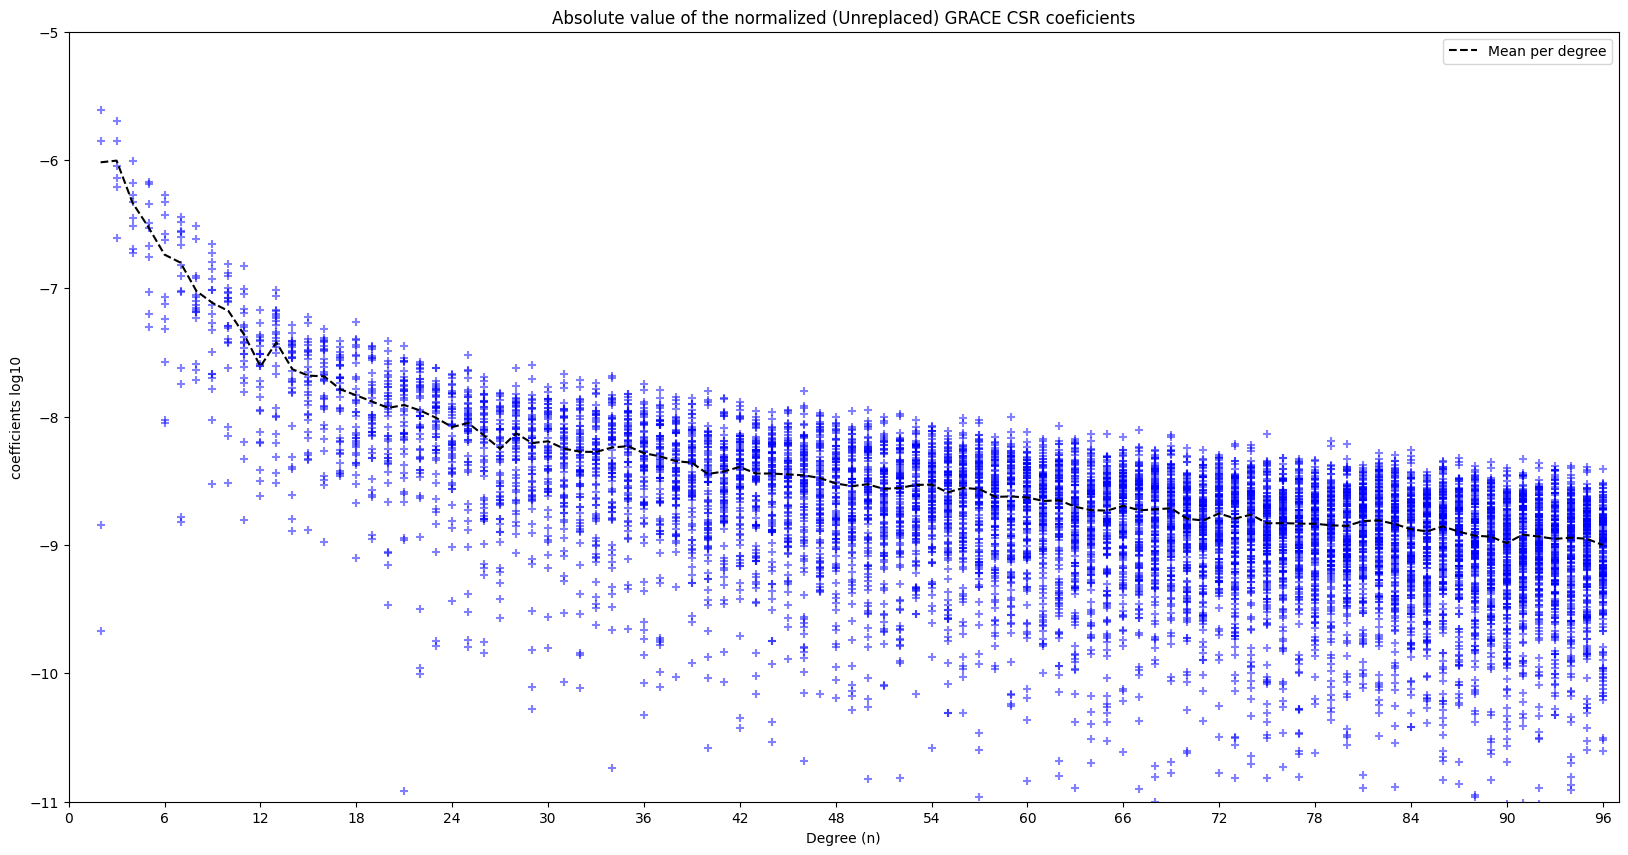

In [33]:
fig, ax = plt.subplots(figsize=(20, 10))
degree_mean = []
for i in range(97):
    desparsed = np.absolute(de_sparse(csr_sc[i, :]))
    degree_mean.append(np.mean(desparsed))
    x = i * np.ones((len(desparsed)))

    ax.scatter(x, np.log10(desparsed), color='blue', marker='+', alpha=0.5)

ax.plot(range(97), np.log10(degree_mean), 'k', linestyle='--', label="Mean per degree")

x_vec = np.arange(0, 96+1, 6)

plt.ylim([-11, -5])
plt.xlim([0, 97])
plt.ylabel("coefficients log10")
plt.xlabel("Degree (n)")
plt.xticks(x_vec)
plt.title("Absolute value of the normalized (Unreplaced) GRACE CSR coeficients")
plt.legend()
plt.show()